In [ ]:
#@title https://github.com/AvivSham/SRGAN-Keras-Implementation

In [ ]:
#@title Download DIV2K Dataset
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2021-06-13 08:59:20--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2021-06-13 08:59:21--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  17.5MB/s    in 3m 5s   

2021-06-13 09:02:27 (18.2 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [ ]:


#@title Import Dependencies
import  os,shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm.notebook import tqdm
from PIL import Image
from skimage.transform import resize

from keras.models import Input, Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.callbacks import ReduceLROnPlateau



In [ ]:
#@title Creating folder for the data and unziping the file
!mkdir train_data
shutil.move('./DIV2K_train_HR.zip','./train_data')
os.chdir('./train_data')
!unzip DIV2K_train_HR.zip
os.chdir('./DIV2K_train_HR')

In [ ]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:]
    

In [ ]:
#@title Resizing the image

img_list, img_low_list = [], []
for i in os.listdir():
  if '.png' in i:
    img = np.array(Image.open(i).convert("RGB"))
    img_crop = crop_center(img,224,224)
    img_list.append(img_crop)
    img_low_list.append(resize(img_crop,(56,56)))

high_reso_imgs = np.array(img_list)
low_reso_imgs = np.array(img_low_list)

In [ ]:
print(len(img_list))

800


In [ ]:
print(high_reso_imgs.shape, low_reso_imgs.shape)
print(high_reso_imgs[0].shape, low_reso_imgs[0].shape)

(800, 224, 224, 3) (800, 56, 56, 3)
(224, 224, 3) (56, 56, 3)


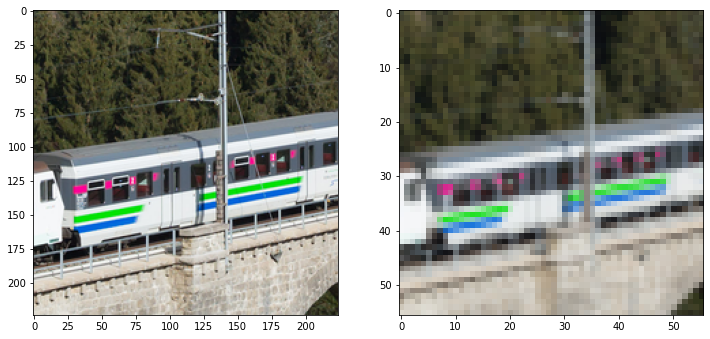

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(high_reso_imgs[0])
plt.subplot(122)
plt.imshow(low_reso_imgs[0])
plt.show()


In [ ]:
os.chdir('/content')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


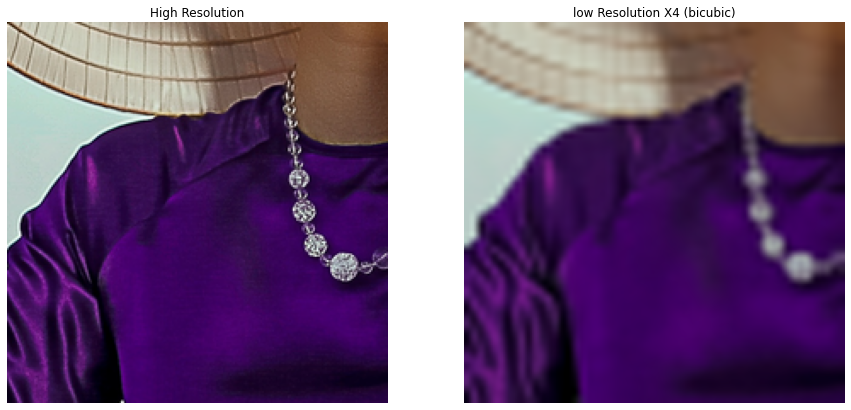

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(high_reso_imgs[2])
plt.grid('off')
plt.axis('off')
plt.title('High Resolution')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(low_reso_imgs[2],(224,224),
                      interpolation = cv2.INTER_CUBIC))
plt.grid('off')
plt.axis('off')
_=plt.title('low Resolution X4 (bicubic)')
plt.show()

In [ ]:

class SRGAN():
  def __init__(self, lr_height=64, lr_width = 64, 
               channels = 3, upscale_factor=4, generator_lr = 1e-4, 
               discriminator_lr=1e-4, gan_lr = 1e-4):
    self.height_low_reso = lr_height
    self.width_low_reso = lr_width

    if upscale_factor % 2 != 0:
      raise ValueError('Upscale factor is invalid, must be product of 2')
    
    self.upscale_factor = upscale_factor
    self.height_high_reso = self.height_low_reso * self.upscale_factor
    self.width_high_reso = self.width_low_reso * self.upscale_factor
    self.channels = channels
    self.shape_low_reso = (self.height_low_reso, self.width_low_reso, self.channels)
    self.shape_high_reso = (self.height_high_reso, self.width_high_reso, self.channels)

    self.samples = high_reso_imgs.shape[0]

    self.opti_generator = Adam(learning_rate=generator_lr)
    self.opti_discriminator = Adam(learning_rate=discriminator_lr)
    self.opti_gan = Adam(learning_rate=gan_lr)

    self.vgg = self.build_vgg()
    print("------------ VGG ------------------")
    print(self.vgg.summary())

    self.discriminator = self.build_discriminator()
    print("------------ discriminator ------------------")
    print(self.discriminator.summary())

    self.discriminator.trainable = False

    self.generator = self.build_generator()
    print("------------ generator ------------------")
    print(self.generator.summary())
    self.gan = self.build_gan()



  def build_vgg(self):
    vgg = VGG19(weights='imagenet')
    vgg_model = Model(inputs=vgg.input, outputs=vgg.layers[9].output)
    img = Input(shape = self.shape_high_reso)
    img_features = vgg_model(img)
    vgg_model = Model(img, img_features)
    vgg_model.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    # vgg.outputs = [vgg.layers[9].output]
    # img = Input(shape = self.shape_high_reso)
    # img_features = vgg(img)
    
    # vgg_model = Model(img, img_features)
    # vgg.model.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    return vgg_model
    
  
  def build_generator(self, n_blocks=16):
    input_layer = Input(self.shape_low_reso)
    
    first_layer = Conv2D(filters=64, kernel_size=9, padding='same')(input_layer)
    first_layer = PReLU()(first_layer)
    residual_blocks = self.residual_block(first_layer)

    for _ in range(n_blocks-1):
      residual_blocks = self.residual_block(residual_blocks)

    output_residual = Conv2D(filters=64, kernel_size=3, padding='same')(residual_blocks)
    output_residual = BatchNormalization(momentum=0.8)(output_residual)
    output_residual = Add()([output_residual, first_layer])

    upsample_layer_1 = self.Upsample_Block(output_residual) # 112
    print(upsample_layer_1)
    upsample_layer_2 = self.Upsample_Block(upsample_layer_1)
    print(upsample_layer_2)
    # print(upsample_layer)
    # print((self.upscale_factor//2) - 1)
    # for i in range((self.upscale_factor//2)):
    #   print("HERE ", i)
    #   upsameple_layer = self.Upsample_Block(upsample_layer)
    #   print(upsample_layer)
    
    gen_output = Conv2D(filters=3, kernel_size=9, padding='same', activation='tanh')(upsample_layer_2)

    gen_model = Model(inputs=input_layer, outputs=gen_output)
    gen_model.compile(loss='binary_crossentropy', optimizer = self.opti_generator)

    return gen_model

  def build_discriminator(self, n_blocks=3, n_filters=64):
    input_layer = Input(self.shape_high_reso)
    discriminator_blocks = self.discriminator_block(input_layer, n_filters, False)

    for i in range(n_blocks):
      discriminator_blocks = self.discriminator_block(discriminator_blocks, n_filters=(i + 1) * 2 * n_filters)

    f_layer = Dense(1024)(discriminator_blocks)
    f_layer = LeakyReLU(alpha=0.2)(f_layer)
    
    dis_output = Dense(units=1, activation='sigmoid')(f_layer)
    dis_model = Model(inputs = input_layer, outputs = dis_output)
    dis_model.compile(loss='mse', optimizer=self.opti_discriminator, metrics=['accuracy'])
    return dis_model

  def build_gan(self):
    dis_input = Input(self.shape_high_reso)
    gen_input = Input(self.shape_low_reso)
    generated_high_reso = self.generator(gen_input)
    generated_features = self.vgg(generated_high_reso)
    generator_valid = self.discriminator(generated_high_reso)
    
    gan_model = Model(inputs = [gen_input, dis_input], outputs = [generator_valid, generated_features] )

    for l in gan_model.layers[-1].layers[-1].layers:
      l.trainable=False
    
    gan_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-2, 1], optimizer='adam')

    return gan_model

  def residual_block(self, input_layer):
    x = Conv2D(filters=64, kernel_size= 3, padding='same')(input_layer)
    x = BatchNormalization(momentum=0.8)(x)
    x = PReLU()(x)
    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    return Add()([input_layer, x])

  def Upsample_Block(self, input_layer):
    x = Conv2D(filters=256, kernel_size=3, padding='same')(input_layer)
    x = self.SubpixelConv2D(2)(x)
    x = PReLU()(x)
    return x
  
  def SubpixelConv2D(self, scale):
    return Lambda(lambda x: tf.nn.depth_to_space(x, scale))
  
  def discriminator_block(self, layer, n_filters, batch_norm=True):
    x = Conv2D(filters=n_filters, kernel_size=3, padding='same')(layer)
    if batch_norm:
      x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=n_filters, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

  def save_gan(self, epoch):
    self.gan.save_weights('/content/weights/gan_weights_epoch_%d.h5'%epoch)
  
  def plot_loss(self, dlosses, glosses, epoch):
    
    fig, ax1 = plt.subplots(figsize=(10, 12))
    color = 'tab:blue'
    ax1.plot(dlosses, color=color, label='D loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('D loss', color=color)
    ax1.tick_params('y', color=color)
    color='tab:green'
    ax2 = ax1.twinx()
    ax2.plot(glosses, color=color, label='G loss')
    ax2.set_ylabel('G loss', color=color)
    ax2.tick_params('y', color=color)
    plt.title('D & G losses')
    plt.savefig('/content/plots/losses_%d.png'%epoch)
    plt.show()
  
  def plot_sample_image(self):
    plt.figure(figsize = (15,15))
    plt.subplot(1,3,1)
    plt.imshow(high_reso_imgs[2])
    plt.grid('off')
    plt.axis('off')
    plt.title('High Resolution')

    plt.subplot(1,3,2)
    plt.imshow(cv2.resize(low_reso_imgs[2],(224,224),
                          interpolation = cv2.INTER_CUBIC))
    plt.grid('off')
    plt.axis('off')
    plt.title('low Resolution X4 (bicubic)')

    im1 = np.copy(low_reso_imgs[2])
    im1 = im1.reshape((1, 56, 56, 3))
    gen_imgs = self.generator.predict(im1)
    plt.subplot(1,3,3)
    plt.imshow(gen_imgs[0])
    plt.grid('off')
    plt.axis('off')
    plt.title('SRGAN)')
    plt.show()
  
  def gen_pipeline(self, batch_size=16):
    while(1):
      indx_high = np.random.randint(0, high_reso_imgs.shape[0]-1, batch_size)
      indx_low = np.random.randint(0, low_reso_imgs.shape[0]-1, batch_size)

      real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
      fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])
      
      norm_hr = high_reso_imgs[indx_high] / 127.5 - 1
      norm_lr = low_reso_imgs[indx_low] / 127.5 - 1
      yield(norm_hr, real, norm_lr, fake)
  
  def vgg_pipeline(self, batch_size=16):
    while(1):
      indx_high = np.random.randint(0, high_reso_imgs.shape[0]-1, batch_size)
      real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
      norm_hr = high_reso_imgs[indx_high] / 127.5 - 1
      norm_lr = low_reso_imgs[indx_high] / 127.5 - 1
      yield(norm_hr, norm_lr, real)

  
  def train(self, epochs, save_interval=100, batch_size=16):
    pipeline= self.gen_pipeline(batch_size)
    vgg_pipeline = self.vgg_pipeline(batch_size)

    batch_count = self.samples//batch_size
    dlosses = []
    glosses = []
    for epo in range(1, epochs + 1):
      print('-'*15, 'Epoch %d' % epo, '-'*15)
      for _ in tqdm(range(batch_count)):
        hr_imgs, real, lr_imgs, fake = next(pipeline)
        generated_hr_imgs = self.generator.predict(lr_imgs)
        real_dis_loss = self.discriminator.train_on_batch(hr_imgs, real)
        fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imgs, fake)
        dis_loss = (0.5*np.add(real_dis_loss, fake_dis_loss))
        hr_imgs, lr_imgs, real = next(vgg_pipeline)
        img_features = self.vgg.predict(hr_imgs)
        gan_loss = self.gan.train_on_batch([lr_imgs, hr_imgs], [real, img_features])
      
      dlosses.append(gan_loss[1])
      glosses.append(gan_loss[0])
      print('\n',dlosses[-1],glosses[-1])
      if epo % save_interval == 0:
        self.save_gan(epo)
        self.plot_loss(dlosses, glosses, epo)
        self.plot_sample_image()

    



In [ ]:
model_srgan = SRGAN(lr_height=56, lr_width=56, channels=3, upscale_factor=4)

------------ VGG ------------------
Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_58 (Functional)        (None, 56, 56, 256)       1735488   
Total params: 1,735,488
Trainable params: 1,735,488
Non-trainable params: 0
_________________________________________________________________
None
------------ discriminator ------------------
Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_541 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
leaky_re_

In [ ]:
model_srgan.train(100, 5, 16)

In [ ]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 4):
  plt.figure(figsize = (12,12))
  plt.tight_layout()
  k = 0
  for i in range(0,n_imgs*3,3):
    k = k + 1
    idx = k # np.random.randint(0,low_reso_imgs.shape[0]-1)
    plt.subplot(n_imgs,3,i+1)
    plt.imshow(high_reso_imgs[idx])
    plt.grid('off')
    plt.axis('off')
    plt.title('Source')
    plt.subplot(n_imgs,3,i+2)
    plt.imshow(cv2.resize(low_reso_imgs[idx],(256,256),
                      interpolation = cv2.INTER_CUBIC))
    plt.grid('off')
    plt.axis('off')
    plt.title('X4 (bicubic)')
    
    img = srgan_model.generator.predict(np.expand_dims(low_reso_imgs[idx], axis = 0) / 127.5 - 1)
    img_unnorm = (img+1) * 127.5
    plt.subplot(n_imgs,3,i+3)
    plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8))
    plt.grid('off')
    plt.axis('off')
    plt.title('SRGAN')
    
  plt.savefig('predicted.png')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


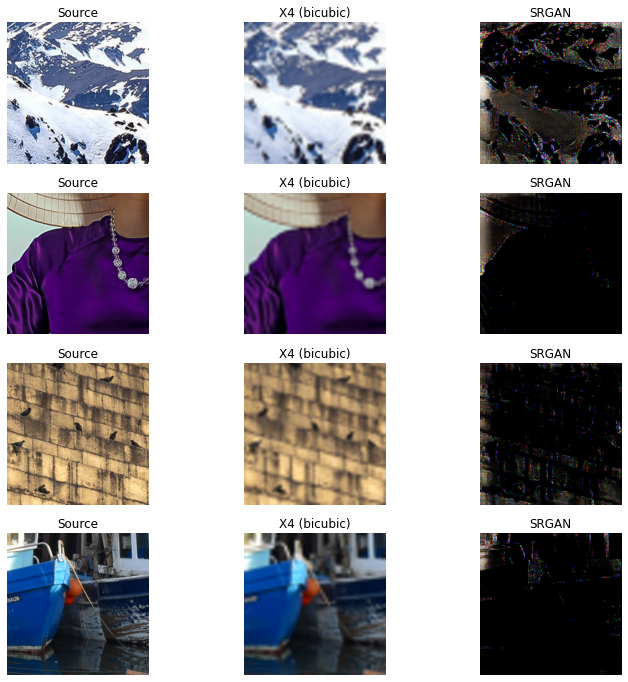

In [ ]:
# Load pretrained model
model_srgan.gan.load_weights('/content/weights/gan_weights_epoch_100.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('gan_weights_epoch_95.h5')
model_srgan.train(500, save_interval=20 ,batch_size=16)